### Prototypical Projection Based Anomaly Detector
###   Code by F. Vides, E. Segura, C. Vargas
###   For Paper, "On Operator Theory-Based Anomaly Detection in Cyber-Physical Systems"
###   by F. Vides, E. Segura, C. Vargas
### @authors: F. Vides, E. Segura, C. Vargas

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.linalg import hankel, solve, norm
import time
import os
from numpy.linalg import svd
from numpy import zeros, where, nan, ones
from statistics import mean,stdev

In [2]:
def InversePowerMethod(A,tol, kIterMax,q0):
    
    n = A.shape[0]

    x = np.random.rand(n).reshape(-1,1)

    B = A.copy()

    error = 1
    
    #First Run
    for od in range(n):
            B[od,od] = A[od,od] - q0
        
    x = np.linalg.solve(B,x)
    x = x/np.linalg.norm(x)
    lamOld = x.T@A@x
    
    kIter = 1
    
    while kIter < kIterMax:
        
        #od = on diagonal
        for od in range(n):
            B[od,od] = A[od,od] - lamOld
        
        x = np.linalg.solve(B,x)
        x = x/np.linalg.norm(x)
        lamNew = x.T@A@x
        kIter = kIter + 1
        
        error = np.abs(lamNew - lamOld)
        if error < tol:
            return (x, lamNew, kIter)
        else:
            lamOld = lamNew
        
        
        
    return (x, lamNew, kIter)

In [3]:
def runTimesProd(signal, nruns, L, N_hankel):


    time_SVD_H = np.zeros(nruns)
    pTdotH_SVD_H = np.zeros(nruns)
    pTdotH1_SVD_H = np.zeros(nruns)
    
    time_SVD_H1 = np.zeros(nruns)
    pTdotH_SVD_H1 = np.zeros(nruns)
    pTdotH1_SVD_H1 = np.zeros(nruns)
    
    
    time_eigh = np.zeros(nruns)
    pTdotH_eigh = np.zeros(nruns)
    pTdotH1_eigh = np.zeros(nruns)
    
    
    #q0 Known
    time_IPM = np.zeros(nruns)
    pTdotH_IPM = np.zeros(nruns)
    pTdotH1_IPM = np.zeros(nruns)
    IPM_kIter = np.zeros(nruns)
    IPM_sigmamin = np.zeros(nruns)
    
        
    
    X = pd.read_csv(signal, header = None)
    x1 = X.values
    xm = np.mean(x1)
    x0 = x1 - xm
    H = hankel(x0[:L],x0[(L-1):N_hankel])
    
    H1 = H@H.T
    
    #To get the smallest singular value
    #This can be estimated by other methods
    #But let's take it as a known.
    
    s = np.linalg.svd(H1,full_matrices=0)[1]
    sigma_min = s[-1]
    
    
    for i in range(nruns):
        startTime = time.time()
        u = np.linalg.svd(H,full_matrices=0)[0]     
        p = u[:,-1]
        finishTime = time.time()
        
        time_SVD_H[i] = finishTime - startTime
        pTdotH_SVD_H[i] = np.linalg.norm(p.T@H)
        pTdotH1_SVD_H[i] = np.linalg.norm(p.T@H1)
    
    
    
    for i in range(nruns):
        startTime = time.time()
        H1 = H@H.T
        u = np.linalg.svd(H1,full_matrices=0)[0]   
        p = u[:,-1]
        finishTime = time.time()
        
        time_SVD_H1[i] = finishTime - startTime
        pTdotH_SVD_H1[i] = np.linalg.norm(p.T@H)
        pTdotH1_SVD_H1[i] = np.linalg.norm(p.T@H1)
        
        
        
    for i in range(nruns):
        startTime = time.time()
        H1 = H@H.T
        eigval, eigvec = np.linalg.eigh(H1)
        p = eigvec[:,0]
        finishTime = time.time()
        
        time_eigh[i] = finishTime - startTime
        pTdotH_eigh[i] = np.linalg.norm(p.T@H)
        pTdotH1_eigh[i] = np.linalg.norm(p.T@H1)
    
    
    for i in range(nruns):
        startTime = time.time()
        H1 = H@H.T
        p, lamNew, kIter = InversePowerMethod(A=H1, tol=1e-8, kIterMax = 200, q0 = (sigma_min + 1e-4)  ) 
        finishTime = time.time()    

        time_IPM[i] = finishTime - startTime
        pTdotH_IPM[i] = np.linalg.norm(p.T@H)
        pTdotH1_IPM[i] = np.linalg.norm(p.T@H1)
        IPM_kIter[i] = kIter
        IPM_sigmamin[i] = lamNew
    
    return( {"time_SVD_H":time_SVD_H,  # SVD H
             "pTdotH_SVD_H":pTdotH_SVD_H,
             "pTdotH1_SVD_H":pTdotH1_SVD_H,
             "time_SVD_H1":time_SVD_H1, # SVD H1
             "pTdotH_SVD_H1":pTdotH_SVD_H1,
             "pTdotH1_SVD_H1":pTdotH1_SVD_H1,
             "time_eigh":time_eigh,  # eigH
             "pTdotH_eigh":pTdotH_eigh,
             "pTdotH1_eigh":pTdotH1_eigh,
             "time_IPM":time_IPM, # IPM 
             "pTdotH_IPM":pTdotH_IPM,
             "pTdotH1_IPM":pTdotH1_IPM,
             "IPM_kIter":IPM_kIter,
             "IPM_sigmamin":IPM_sigmamin,
             "signals":signal} )

In [4]:
filesList = os.listdir("../Data/")
signalsList = ["../Data/"+ x for x in filesList if x[-4:] == ".csv"]
signalsList.sort()

In [5]:
signalsList

['../Data/real_signal_1.csv',
 '../Data/real_signal_2.csv',
 '../Data/synthetic_signal.csv']

### We set the L and N_hankel to the same as reported on the figures of the paper

In [6]:
L = (75, 90,150)
N_hankel = (1300, 900, 1200)

In [7]:
df = pd.DataFrame()

for i in range(len(signalsList) ):
    df = pd.concat([df, pd.DataFrame(runTimesProd(signalsList[i],
                                                     nruns = 1000,
                                                     L = L[i],
                                                     N_hankel = N_hankel[i])  )  ] )

### Cleaning the signals names that are the same as the file

In [8]:
df["signals"] = df["signals"].apply(lambda x: x.split("/")[2])
df["signals"] = df["signals"].apply(lambda x: x.split(".")[0])

In [9]:
df.to_csv("../times_result/times_and_matrix_product_H_H1.csv", index=False)

In [10]:
df = pd.read_csv("../times_result/times_and_matrix_product_H_H1.csv")

In [11]:
df.head()

,time_SVD_H,pTdotH_SVD_H,pTdotH1_SVD_H,time_SVD_H1,pTdotH_SVD_H1,pTdotH1_SVD_H1,time_eigh,pTdotH_eigh,pTdotH1_eigh,time_IPM,pTdotH_IPM,pTdotH1_IPM,IPM_kIter,IPM_sigmamin,signals
0,0.071244,48.093876,2313.020908,0.011352,48.093876,2313.020908,0.002222,48.093876,2313.020908,0.001795,48.093876,2313.020908,2.0,2313.020908,real_signal_1
1,0.108504,48.093876,2313.020908,0.011279,48.093876,2313.020908,0.001795,48.093876,2313.020908,0.001310,48.093876,2313.020908,2.0,2313.020908,real_signal_1
2,0.097593,48.093876,2313.020908,0.011264,48.093876,2313.020908,0.001813,48.093876,2313.020908,0.001306,48.093876,2313.020908,2.0,2313.020908,real_signal_1
3,0.077326,48.093876,2313.020908,0.011250,48.093876,2313.020908,0.001741,48.093876,2313.020908,0.001756,48.093876,2313.020908,3.0,2313.020908,real_signal_1
4,0.112360,48.093876,2313.020908,0.011247,48.093876,2313.020908,0.001761,48.093876,2313.020908,0.001302,48.093876,2313.020908,2.0,2313.020908,real_signal_1


In [12]:
df.describe()

,time_SVD_H,pTdotH_SVD_H,pTdotH1_SVD_H,time_SVD_H1,pTdotH_SVD_H1,pTdotH1_SVD_H1,time_eigh,pTdotH_eigh,pTdotH1_eigh,time_IPM,pTdotH_IPM,pTdotH1_IPM,IPM_kIter,IPM_sigmamin
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,0.074733,16.612490,771.870136,0.008864,16.612490,771.870136,0.003662,16.612490,771.870136,0.008863,16.612605,771.870199,3.401667,771.870199
std,0.086082,22.272419,1089.940331,0.007136,22.272419,1089.940331,0.001805,22.272419,1089.940331,0.014696,22.272335,1089.940286,1.314625,1089.940286
min,0.009438,0.140552,0.019755,0.002094,0.140552,0.019755,0.001741,0.140552,0.019755,0.001250,0.140552,0.019755,2.000000,0.019755
25%,0.011375,0.140552,0.019755,0.004308,0.140552,0.019755,0.001939,0.140552,0.019755,0.001359,0.140641,0.019780,2.000000,0.019780
50%,0.040644,1.603042,2.569744,0.008480,1.603042,2.569744,0.003139,1.603042,2.569744,0.002839,1.603042,2.569744,3.000000,2.569744
75%,0.091780,48.093876,2313.020908,0.011237,48.093876,2313.020908,0.005600,48.093876,2313.020908,0.008574,48.093876,2313.020908,4.000000,2313.020908
max,0.528109,48.093876,2313.020908,0.084405,48.093876,2313.020908,0.019772,48.093876,2313.020908,0.201398,48.093876,2313.020908,10.000000,2313.020908


## Let's make plots for the times

In [13]:
df_times = pd.melt(df, id_vars = ["signals"], value_vars = ["time_SVD_H","time_SVD_H1","time_eigh","time_IPM"], var_name = "method",
       value_name = "times")

In [14]:
df_times

,signals,method,times
0,real_signal_1,time_SVD_H,0.071244
1,real_signal_1,time_SVD_H,0.108504
2,real_signal_1,time_SVD_H,0.097593
3,real_signal_1,time_SVD_H,0.077326
4,real_signal_1,time_SVD_H,0.112360
...,...,...,...
11995,synthetic_signal,time_IPM,0.051728
11996,synthetic_signal,time_IPM,0.047559
11997,synthetic_signal,time_IPM,0.051698
11998,synthetic_signal,time_IPM,0.015628


### With outliers

<AxesSubplot:xlabel='times', ylabel='signals'>

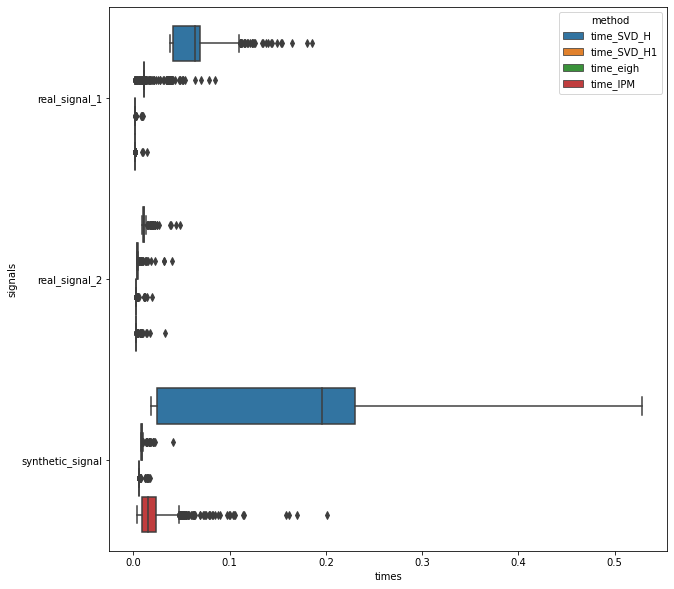

In [15]:
plt.figure(figsize = (10,10))
sns.boxplot(x = "times",
            y = "signals",
            data = df_times,
            hue = "method")

### Without outliers

<AxesSubplot:xlabel='times', ylabel='signals'>

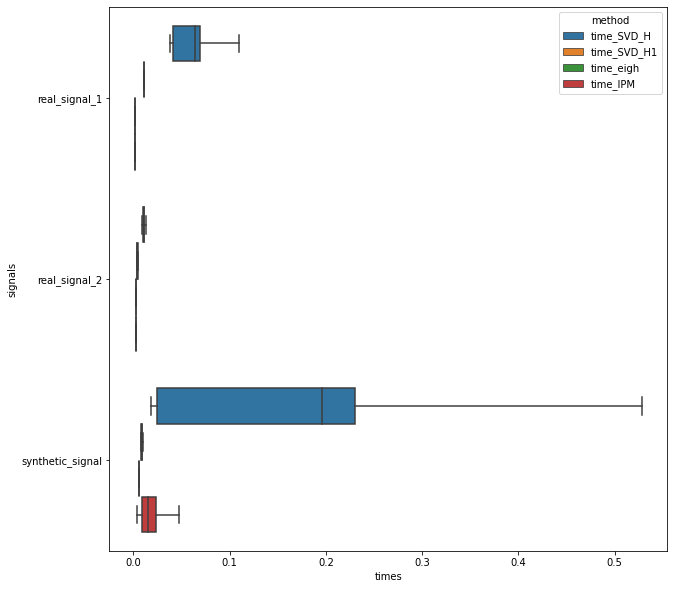

In [16]:
plt.figure(figsize = (10,10))
sns.boxplot(x = "times",
            y = "signals",
            data = df_times,
            hue = "method",
            showfliers = False)

In [17]:
df_times['method'].isin(["time_SVD_H1","time_eigh","time_IPM"])

0        False
1        False
2        False
3        False
4        False
         ...  
11995     True
11996     True
11997     True
11998     True
11999     True
Name: method, Length: 12000, dtype: bool

In [24]:
df_times2 = df_times[~df_times['method'].isin(["time_SVD_H1"])]

In [25]:
df_times2

,signals,method,times
0,real_signal_1,time_SVD_H,0.071244
1,real_signal_1,time_SVD_H,0.108504
2,real_signal_1,time_SVD_H,0.097593
3,real_signal_1,time_SVD_H,0.077326
4,real_signal_1,time_SVD_H,0.112360
...,...,...,...
11995,synthetic_signal,time_IPM,0.051728
11996,synthetic_signal,time_IPM,0.047559
11997,synthetic_signal,time_IPM,0.051698
11998,synthetic_signal,time_IPM,0.015628


<AxesSubplot:xlabel='times', ylabel='signals'>

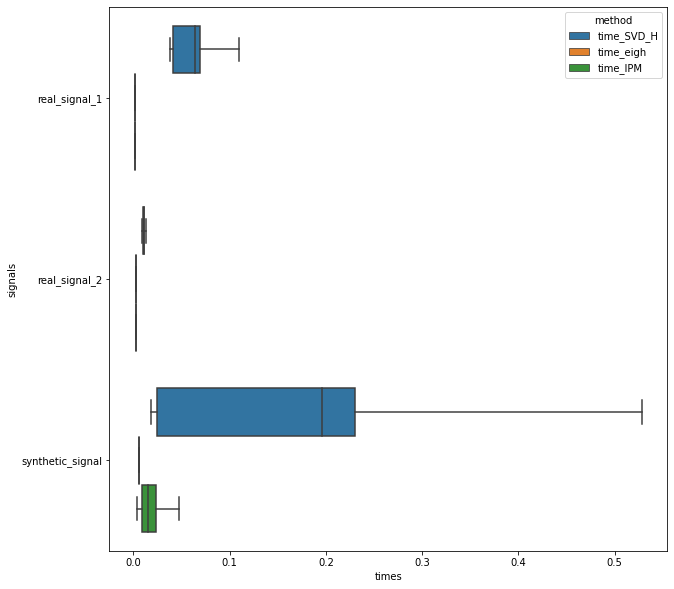

In [26]:
plt.figure(figsize = (10,10))
sns.boxplot(x = "times",
            y = "signals",
            data = df_times2,
            hue = "method",
            showfliers = False)

In [27]:
df_prom = df.groupby("signals").mean()
df_prom

,time_SVD_H,pTdotH_SVD_H,pTdotH1_SVD_H,time_SVD_H1,pTdotH_SVD_H1,pTdotH1_SVD_H1,time_eigh,pTdotH_eigh,pTdotH1_eigh,time_IPM,pTdotH_IPM,pTdotH1_IPM,IPM_kIter,IPM_sigmamin
signals,,,,,,,,,,,,,,
real_signal_1,0.058666,48.093876,2313.020908,0.013279,48.093876,2313.020908,0.001927,48.093876,2313.020908,0.001452,48.093876,2313.020908,2.238,2313.020908
real_signal_2,0.011187,1.603042,2.569744,0.004484,1.603042,2.569744,0.003222,1.603042,2.569744,0.003188,1.603073,2.569844,3.055,2.569844
synthetic_signal,0.154346,0.140552,0.019755,0.008828,0.140552,0.019755,0.005837,0.140552,0.019755,0.021947,0.140865,0.019845,4.912,0.019845


In [28]:
print(df_prom.style.to_latex())

\begin{tabular}{lrrrrrrrrrrrrrr}
 & time_SVD_H & pTdotH_SVD_H & pTdotH1_SVD_H & time_SVD_H1 & pTdotH_SVD_H1 & pTdotH1_SVD_H1 & time_eigh & pTdotH_eigh & pTdotH1_eigh & time_IPM & pTdotH_IPM & pTdotH1_IPM & IPM_kIter & IPM_sigmamin \\
signals &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
real_signal_1 & 0.058666 & 48.093876 & 2313.020908 & 0.013279 & 48.093876 & 2313.020908 & 0.001927 & 48.093876 & 2313.020908 & 0.001452 & 48.093876 & 2313.020908 & 2.238000 & 2313.020908 \\
real_signal_2 & 0.011187 & 1.603042 & 2.569744 & 0.004484 & 1.603042 & 2.569744 & 0.003222 & 1.603042 & 2.569744 & 0.003188 & 1.603073 & 2.569844 & 3.055000 & 2.569844 \\
synthetic_signal & 0.154346 & 0.140552 & 0.019755 & 0.008828 & 0.140552 & 0.019755 & 0.005837 & 0.140552 & 0.019755 & 0.021947 & 0.140865 & 0.019845 & 4.912000 & 0.019845 \\
\end{tabular}



In [32]:
print(df_prom[["time_IPM","time_eigh","time_SVD_H1","time_SVD_H"]].style.to_latex())

\begin{tabular}{lrrrr}
 & time_IPM & time_eigh & time_SVD_H1 & time_SVD_H \\
signals &  &  &  &  \\
real_signal_1 & 0.001452 & 0.001927 & 0.013279 & 0.058666 \\
real_signal_2 & 0.003188 & 0.003222 & 0.004484 & 0.011187 \\
synthetic_signal & 0.021947 & 0.005837 & 0.008828 & 0.154346 \\
\end{tabular}

